# Food Stamps Application Analysis

Sergio Nieto

_Analysis of the likelihood of using food stamps using the information from the PUMS datasets._

## Initial Objectives

1. If the data is too large for the analysis, what will you do to reduce the size of the data, or work with the full dataset? 
2. What is the incidence rate?  Are there enough records for you to build a model? If not, what steps will you take to ensure you can attempt a model with this data.
3. What data makes sense to use as potential features for a model, and which data does not?
4. What data cleansing techniques did you use and why?
5. Prepare your data for model development, explaining the steps you used for that preparation.
6. Make sure to document all the steps you used for building the model(s).
7. Include any relevant metrics that you use to determine if the model is acceptable or not. 
8. Be ready to defend your results. It is fine if you cannot build a model that will successfully predict the likelihood of using food stamps. You just need to be able to explain why that is the case.
9. If you do successfully build a model, test the results on another state, like Texas or California.  Download the data for the appropriate state from https://www2.census.gov/programs-surveys/acs/data/pums/2021/1-Year/.  csv_pca.zip is California, and csv_ptx.zip is Texas.

Dataset is not too large, maybe after merging with more states and more census year info. There are options:

- Use a Database like postgresql or another to kickoff exploratory analysis.
- If not all data is needed at once, it is possible to use chunks of data only agregating when necessary.
- Sometimes, when you know a priori charactericstics of the dataset you can do: load useful columns only, change datatypes (truncating), use sparse representation if too many null values are to be stored.
- Usually recurring to a cloud provider of a database maybe an option.

## Data-Business Understanding

Taking introductory information from documentation:

The Public Use Microdata Sample (PUMS) are a subset of the 2021 American Community Survey (ACS) and Puerto Rico Community Survey (PRCS) samples.

The Census Bureau takes further steps to prevent the identification of specific individuals, households, or housing units, on the PUMS files. The main disclosure avoidance method used is to limit the geographic detail shown in the files. The smallest geographic unit that is identi- fied is the Public Use Microdata Area (PUMA). The current PUMAs were formed based on data and location collected in the 2010 Census and have been used by the ACS PUMS files since the 2012 data year. They do not cross state boundaries.

There are 2 main datasets by State: Housing unit related and Person related. We refer to them as Housing dataset and Population dataset just for simplicity.

Only Population data was provided but the Yearly food stamp/Supplemental Nutrition Assistance Program (SNAP) recipiency variable was available in the Housing dataset so both will be used in the analysis.

Each month, SNAP benefits are added to an electronic benefit transfer (EBT) card to use when you shop for food. ([ref]())

To be eligible for SNAP benefits, you must meet your state’s requirements, including income limits. States can also take other resources into account, like the money you have in your bank, to decide if you qualify for SNAP.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Processing 
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from imblearn.over_sampling import SMOTE

# Sklearn models and evaluation
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_curve, auc, classification_report, ConfusionMatrixDisplay
from sklearn.feature_selection import RFECV

pd.set_option('max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('psam_p05.csv')

In [3]:
dfh = pd.read_csv('psam_house05.csv')

In [4]:
dfh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15208 entries, 0 to 15207
Columns: 241 entries, RT to WGTP80
dtypes: float64(149), int64(90), object(2)
memory usage: 28.0+ MB


In [5]:
dfh.shape, df.shape

((15208, 241), (30050, 287))

In [6]:
dfh.head(3)

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,TYPEHUGQ,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,FULP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MHP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RNTM,RNTP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,VACDUR,VACOTH,VACS,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRNTP,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFSP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FHOTWATP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FPLMPRP,FREFRP,FRMSP,FRNTMP,FRNTP,FRWATP,FRWATPRP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVACDURP,FVACOTHP,FVACSP,FVALP,FVEHP,FWATP,FYRBLTP,WGTP1,WGTP2,WGTP3,WGTP4,WGTP5,WGTP6,WGTP7,WGTP8,WGTP9,WGTP10,WGTP11,WGTP12,WGTP13,WGTP14,WGTP15,WGTP16,WGTP17,WGTP18,WGTP19,WGTP20,WGTP21,WGTP22,WGTP23,WGTP24,WGTP25,WGTP26,WGTP27,WGTP28,WGTP29,WGTP30,WGTP31,WGTP32,WGTP33,WGTP34,WGTP35,WGTP36,WGTP37,WGTP38,WGTP39,WGTP40,WGTP41,WGTP42,WGTP43,WGTP44,WGTP45,WGTP46,WGTP47,WGTP48,WGTP49,WGTP50,WGTP51,WGTP52,WGTP53,WGTP54,WGTP55,WGTP56,WGTP57,WGTP58,WGTP59,WGTP60,WGTP61,WGTP62,WGTP63,WGTP64,WGTP65,WGTP66,WGTP67,WGTP68,WGTP69,WGTP70,WGTP71,WGTP72,WGTP73,WGTP74,WGTP75,WGTP76,WGTP77,WGTP78,WGTP79,WGTP80
0,H,2021GQ0000060,7,700,3,5,1000000,1029928,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,H,2021GQ0000334,7,1900,3,5,1000000,1029928,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,H,2021GQ0000904,7,1100,3,5,1000000,1029928,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


A quick look at datasets shows that information has null values, encoded values and needs to be weighted before aggregating.

In the Population dataset we have repeated ids that correspond to different values in the SPORDER variable. This variable encodes the number of person within a house unit, so I'll use only sporder=1 to refer to the first contributor in the housing unit, this is only to simplify analysis.

In [7]:
df[df['SERIALNO']== '2021HU0811808']

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,CIT,CITWP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPIK,MLPJ,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELSHIPP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK,YOEP,ANC,ANC1P,ANC2P,DECADE,DIS,DRIVESP,ESP,ESR,FOD1P,FOD2P,HICOV,HISP,INDP,JWAP,JWDP,LANP,MIGPUMA,MIGSP,MSP,NAICSP,NATIVITY,NOP,OC,OCCP,PAOC,PERNP,PINCP,POBP,POVPIP,POWPUMA,POWSP,PRIVCOV,PUBCOV,QTRBIR,RAC1P,RAC2P,RAC3P,RACAIAN,RACASN,RACBLK,RACNH,RACNUM,RACPI,RACSOR,RACWHT,RC,SCIENGP,SCIENGRLP,SFN,SFR,SOCP,VPS,WAOB,FAGEP,FANCP,FCITP,FCITWP,FCOWP,FDDRSP,FDEARP,FDEYEP,FDISP,FDOUTP,FDPHYP,FDRATP,FDRATXP,FDREMP,FENGP,FESRP,FFERP,FFODP,FGCLP,FGCMP,FGCRP,FHICOVP,FHIMRKSP,FHINS1P,FHINS2P,FHINS3C,FHINS3P,FHINS4C,FHINS4P,FHINS5C,FHINS5P,FHINS6P,FHINS7P,FHISP,FINDP,FINTP,FJWDP,FJWMNP,FJWRIP,FJWTRNSP,FLANP,FLANXP,FMARP,FMARHDP,FMARHMP,FMARHTP,FMARHWP,FMARHYP,FMIGP,FMIGSP,FMILPP,FMILSP,FOCCP,FOIP,FPAP,FPERNP,FPINCP,FPOBP,FPOWSP,FPRIVCOVP,FPUBCOVP,FRACP,FRELSHIPP,FRETP,FSCHGP,FSCHLP,FSCHP,FSEMP,FSEXP,FSSIP,FSSP,FWAGP,FWKHP,FWKLP,FWKWNP,FWRKP,FYOEP,PWGTP1,PWGTP2,PWGTP3,PWGTP4,PWGTP5,PWGTP6,PWGTP7,PWGTP8,PWGTP9,PWGTP10,PWGTP11,PWGTP12,PWGTP13,PWGTP14,PWGTP15,PWGTP16,PWGTP17,PWGTP18,PWGTP19,PWGTP20,PWGTP21,PWGTP22,PWGTP23,PWGTP24,PWGTP25,PWGTP26,PWGTP27,PWGTP28,PWGTP29,PWGTP30,PWGTP31,PWGTP32,PWGTP33,PWGTP34,PWGTP35,PWGTP36,PWGTP37,PWGTP38,PWGTP39,PWGTP40,PWGTP41,PWGTP42,PWGTP43,PWGTP44,PWGTP45,PWGTP46,PWGTP47,PWGTP48,PWGTP49,PWGTP50,PWGTP51,PWGTP52,PWGTP53,PWGTP54,PWGTP55,PWGTP56,PWGTP57,PWGTP58,PWGTP59,PWGTP60,PWGTP61,PWGTP62,PWGTP63,PWGTP64,PWGTP65,PWGTP66,PWGTP67,PWGTP68,PWGTP69,PWGTP70,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
17706,P,2021HU0811808,7,1,100,3,5,1029928,57,52,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,1.0,NaN,2.0,0,1,2,2,2,2,2,2,30.0,NaN,NaN,11.0,2.0,2,2.0,2.0,1.0,1.0,1992.0,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,20,0.0,1.0,NaN,22.0,20000.0,1,0.0,0.0,135000.0,48.0,1.0,52.0,1.0,NaN,2,22,32,NaN,2,NaN,NaN,1.0,6200.0,6201.0,1,1,6695.0,NaN,NaN,NaN,NaN,NaN,3.0,5182,1,NaN,0.0,110.0,NaN,155000.0,155030.0,49,497.0,100.0,5.0,1,2,4,1,1,1,0,0,0,0,1,0,0,1,0.0,2.0,2.0,NaN,NaN,113021,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,57,51,22,93,56,104,90,50,90,19,65,54,60,16,53,88,52,19,18,70,65,64,16,101,62,89,92,57,87,15,61,65,62,17,56,84,56,18,16,50,65,61,19,96,57,105,102,49,105,16,53,51,56,18,64,97,55,15,17,60,52,52,18,100,52,98,93,72,104,20,61,58,68,15,50,95,53,21,15,59
17707,P,2021HU0811808,7,2,100,3,5,1029928,90,22,1,NaN,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,1,2.0,2.0,1.0,2.0,2017.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,3.0,0.0,0.0,25,0.0,1.0,NaN,19.0,0.0,2,0.0,0.0,0.0,NaN,3.0,NaN,2.0,NaN,2,22,32,NaN,2,NaN,NaN,6.0,NaN,NaN,1,1,NaN,NaN,NaN,NaN,100.0,5.0,1.0,NaN,1,NaN,0.0,NaN,1.0,0.0,0.0,49,497.0,NaN,NaN,1,2,4,1,1,1,0,0,0,0,1,0,0,1,0.0,NaN,NaN,1.0,2.0,NaN,NaN,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0,NaN,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,124,101,22,155,75,129,155,112,155,30,79,93,103,28,90,129,67,25,27,97,110,107,26,164,105,150,128,104,160,29,74,87,104,28,105,155,72,26,26,99,139,90,27,173,84,131,162,93,171,26,95,83,88,28,93,132,88,26,25,107,83,82,30,178,85,131,138,113,166,24,97,100,92,22,86,165,94,24,22,89
17708,P,2021HU0811808,7,3,100,3,5,1029928,81,17,1,NaN,1.0,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,2.0,3.0,3.0,0.0,0.0,25,0.0,3.0,15.0,17.0,0.0,1,0.0,0.0,3000.0,20.0,1.0,8.0,2.0,NaN,2,22,32,NaN

In [8]:
df = df[df['SPORDER'] ==1].reset_index(drop=True)

### Food Stamp incidence rate

It's possible to calculate incidence rate for recepiency of SNAP. According to documentation, the variable is called FS and FS=1 are those housing units that receive the benefits of the program (there are null values meaning the application is vacant).

> We have 10.77% of the housing units receive the benefits.

In [9]:
dfh.loc[dfh['FS']==2, 'FS'] = 0

# No need to do this...

In [64]:
dfh['FS'].value_counts(normalize=True).mul(100).round(2).astype('str')+'%'

0.0    89.23%
1.0    10.77%
Name: FS, dtype: object

In [11]:
# Removing from the Housing dataset those units without FS value.

dfh = dfh[~dfh['FS'].isnull()].reset_index(drop=True)

## Data Preprocessing

In [12]:
# We need to know if there are shared ids:

dfh['SERIALNO'].isin(df['SERIALNO']).sum(), df['SERIALNO'].isin(dfh['SERIALNO']).sum()

(13615, 13615)

Understanding the datasets variables is crucial for reducing the number of variables before looking into correlations.

- Droping RT, Division, Region, ST because we have the PUMA.

### RECORD-HOUSING UNIT VARIABLES 

Some housing variables are binary and related to availability of certain characteristics of the house like internet or water mgmt.

I'll keep almost all variables, droping only those that may imply same capabilities for the household in the unit. 

For example, DIALUP is related to a Dial-up service access to internet in the region, so it may not be a good explicative variable because in other states will change just because geography and different infrastructure. It may be better to use internet access only or a varible related to the usage of internet, like a home business.

In [13]:
dfh['DIALUP'].value_counts()

2.0    10066
1.0      288
Name: DIALUP, dtype: int64

In [14]:
dfh.groupby(['DIALUP'])['FS'].sum().reset_index().sort_values('FS', ascending=False)

,DIALUP,FS
1,2.0,1057.0
0,1.0,24.0


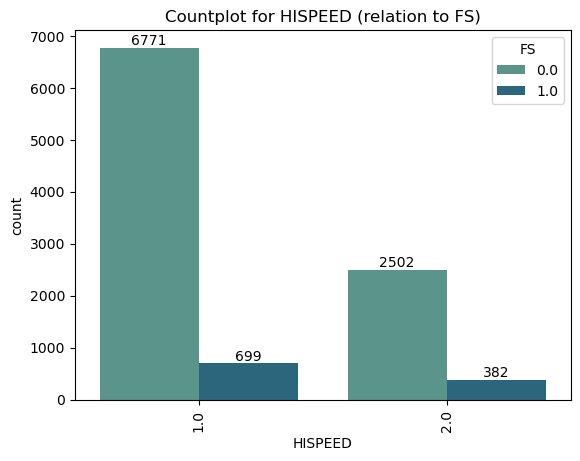

In [15]:
# A variable related to internet but more related to income possibilities is HISPEED

# Broadband (high speed) Internet service such as cable, fiber optic, or  DSL service. 

# HISPEED=1 means the housing unit has acces to this service.

p = 'crest'
ax = sns.countplot(data=dfh, 
                   x='HISPEED',
                   hue="FS", 
                   palette=p, 
                   order=dfh['HISPEED'].value_counts().index)
ax.set_title('Countplot for HISPEED (relation to FS)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for container in ax.containers:
    ax.bar_label(container)

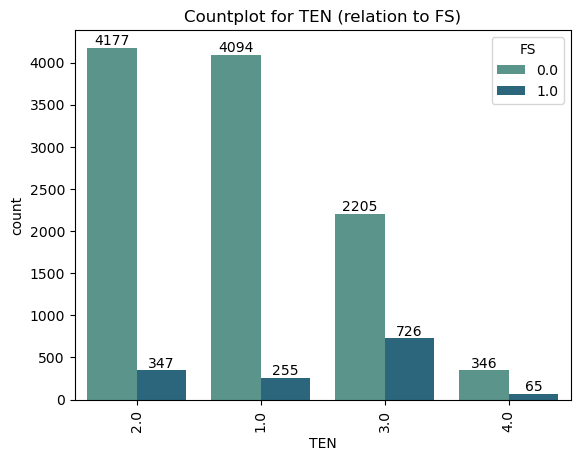

In [16]:
# Just to show another categorical variable, let's see TEN

# Tenure or how persons related to the housing are living 

# b .N/A (GQ/vacant) 
# 1 .Owned with mortgage or loan (include home equity loans) 
# 2 .Owned free and clear 
# 3 .Rented 
# 4 .Occupied without payment of rent

p = 'crest'
ax = sns.countplot(data=dfh, 
                   x='TEN',
                   hue="FS", 
                   palette=p, 
                   order=dfh['TEN'].value_counts().index)
ax.set_title('Countplot for TEN (relation to FS)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for container in ax.containers:
    ax.bar_label(container)

# We can see that for owned housing, less than 10% apply for a Food stamp,

# but for rented and occupied the proportion increase to more than 20%

### RECORD-HOUSEHOLD VARIABLES 

This variales include income and family characteristics that may become relevant for the analysis. Some of them will be droped like race related (to avoid bias in the possible model) but I'll keep one language variable to account for a possible relationship.

Theres is also the problem of weighting the values like income according to the size of the sample in the survey. According to documentation:

_Each housing and person record is assigned a weight, because the records in the PUMS files represent a sam- ple of the population. The weight is a numeric variable expressing the number of housing units or people that an individual microdata record represents. The sum of the housing unit and person weights for a geographic area is equal to the estimate of the total number of housing units and people in that area. To generate estimates based on the PUMS records, data users must correctly apply weights._

_When working with a merged file that includes both housing and person records, person weights should be used to produce estimates for person characteristics..._

_There are two additional sets of weights, one for households ranging from WGTP1 to WGTP80, and one for individuals ranging from PWGTP1 to PWGTP80. These “replicate weights” are used to calculate the error associated with each estimate. For more informa- tion about replicate weights, see the section below on “Data Quality in the ACS PUMS.”
TIP: To generate statistics for housing units or house- holds (for example, data on average household income), data users should apply the PUMS household weights (WGTP). To generate statistics for individuals (such as age or educational attainment), data users should apply the PUMS person weights (PWGTP)._

I'll drop WGTP and PWGTP since they're related to error analysis.

In [17]:
pwgt_cols = list(df.columns)
hwgt_cols = list(dfh.columns)

In [18]:
p_to_drop = [x for x in pwgt_cols if ('WGTP' in x)]
h_to_drop = [x for x in hwgt_cols if ('WGTP' in x)]

In [19]:
# Only keeping the first member of the list
p_to_drop.remove('PWGTP')
h_to_drop.remove('WGTP')
p_to_drop[:3], h_to_drop[:3]

(['PWGTP1', 'PWGTP2', 'PWGTP3'], ['WGTP1', 'WGTP2', 'WGTP3'])

In [22]:
# Add unused variables in each case, population and housing:

np_to_drop = ['RT', 'DIVISION', 'SPORDER', 'PUMA', 'REGION' , 'ST', 'AGEP', 'CIT', 'CITWP',
              # Drop all PERSON RECORD-RECODED PERSON VARIABLES to simplify and maybe avoid duplicate info
              'ANC', 'ANC1P', 'ANC2P', 'DECADE', 'DIS', 'DRIVESP', 'ESP', 'ESR',
       'FOD1P', 'FOD2P', 'HICOV', 'HISP', 'INDP', 'JWAP', 'JWDP', 'LANP',
       'MIGPUMA', 'MIGSP', 'MSP', 'NAICSP', 'NATIVITY', 'NOP', 'OC', 'OCCP', 
              'PAOC', 'PERNP', 'PINCP', 'POBP', 'POVPIP', 'POWPUMA', 'POWSP',
       'PRIVCOV', 'PUBCOV', 'QTRBIR', 'RAC1P', 'RAC2P', 'RAC3P', 'RACAIAN',
       'RACASN', 'RACBLK', 'RACNH', 'RACNUM', 'RACPI', 'RACSOR', 'RACWHT',
       'RC', 'SCIENGP', 'SCIENGRLP', 'SFN', 'SFR', 'SOCP', 'VPS', 'WAOB',
       'FAGEP', 'FANCP', 'FCITP', 'FCITWP', 'FCOWP', 'FDDRSP', 'FDEARP',
       'FDEYEP', 'FDISP', 'FDOUTP', 'FDPHYP', 'FDRATP', 'FDRATXP', 'FDREMP',
       'FENGP', 'FESRP', 'FFERP', 'FFODP', 'FGCLP', 'FGCMP', 'FGCRP', 'FHICOVP', 
              'FHIMRKSP', 'FHINS1P', 'FHINS2P', 'FHINS3C',
       'FHINS3P', 'FHINS4C', 'FHINS4P', 'FHINS5C', 'FHINS5P', 'FHINS6P',
       'FHINS7P', 'FHISP', 'FINDP', 'FINTP', 'FJWDP', 'FJWMNP', 'FJWRIP',
       'FJWTRNSP', 'FLANP', 'FLANXP', 'FMARP', 'FMARHDP', 'FMARHMP', 'FMARHTP',
       'FMARHWP', 'FMARHYP', 'FMIGP', 'FMIGSP', 'FMILPP', 'FMILSP', 'FOCCP',
       'FOIP', 'FPAP', 'FPERNP', 'FPINCP', 'FPOBP', 'FPOWSP', 'FPRIVCOVP',
       'FPUBCOVP', 'FRACP', 'FRELSHIPP', 'FRETP', 'FSCHGP', 'FSCHLP', 'FSCHP',
       'FSEMP', 'FSEXP', 'FSSIP', 'FSSP', 'FWAGP', 'FWKHP', 'FWKLP', 'FWKWNP',
       'FWRKP', 'FYOEP'] + p_to_drop

nh_to_drop = ['RT', 'DIVISION', 'REGION' , 'ST' ] + h_to_drop

In [24]:
df.drop(columns = np_to_drop, inplace=True)
dfh.drop(columns = nh_to_drop, inplace=True)

In [28]:
dfh.columns[:12]

Index(['SERIALNO', 'PUMA', 'ADJHSG', 'ADJINC', 'WGTP', 'NP', 'TYPEHUGQ',
       'ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP'],
      dtype='object')

In [27]:
df.columns

Index(['SERIALNO', 'ADJINC', 'PWGTP', 'COW', 'DDRS', 'DEAR', 'DEYE', 'DOUT',
       'DPHY', 'DRAT', 'DRATX', 'DREM', 'ENG', 'FER', 'GCL', 'GCM', 'GCR',
       'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',
       'INTP', 'JWMNP', 'JWRIP', 'JWTRNS', 'LANX', 'MAR', 'MARHD', 'MARHM',
       'MARHT', 'MARHW', 'MARHYP', 'MIG', 'MIL', 'MLPA', 'MLPB', 'MLPCD',
       'MLPE', 'MLPFG', 'MLPH', 'MLPIK', 'MLPJ', 'NWAB', 'NWAV', 'NWLA',
       'NWLK', 'NWRE', 'OIP', 'PAP', 'RELSHIPP', 'RETP', 'SCH', 'SCHG', 'SCHL',
       'SEMP', 'SEX', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN', 'WRK',
       'YOEP'],
      dtype='object')

Now, we try a left join from Population data to the Housing dataset

In [29]:
dfh.shape, df.shape

((13615, 157), (13615, 68))

In [30]:
# The new merged dataframe will be called pums, after merging we can use the id SERIALNO as index

# 

pums = pd.merge(dfh, df, on="SERIALNO", how="left")
pums.shape

(13615, 224)

In [31]:
pums.set_index('SERIALNO', inplace=True)
pums.drop(columns=['ADJINC_x','ADJINC_y','ADJHSG'],inplace=True) # We do not need adjusment values for this analysis

In [32]:
pums['ACCESSINET'].describe()

count    12215.000000
mean         1.281948
std          0.679471
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          3.000000
Name: ACCESSINET, dtype: float64

In [33]:
pums.head() #ADJINC_y = 1029928

,PUMA,WGTP,NP,TYPEHUGQ,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,FULP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MHP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RNTM,RNTP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,SMP,STOV,TABLET,TEL,TEN,VACDUR,VACOTH,VACS,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRNTP,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFSP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FHOTWATP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FPLMPRP,FREFRP,FRMSP,FRNTMP,FRNTP,FRWATP,FRWATPRP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVACDURP,FVACOTHP,FVACSP,FVALP,FVEHP,FWATP,FYRBLTP,PWGTP,COW,DDRS,DEAR,DEYE,DOUT,DPHY,DRAT,DRATX,DREM,ENG,FER,GCL,GCM,GCR,HIMRKS,HINS1,HINS2,HINS3,HINS4,HINS5,HINS6,HINS7,INTP,JWMNP,JWRIP,JWTRNS,LANX,MAR,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,MLPA,MLPB,MLPCD,MLPE,MLPFG,MLPH,MLPIK,MLPJ,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RELSHIPP,RETP,SCH,SCHG,SCHL,SEMP,SEX,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK,YOEP
SERIALNO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021GQ0000060,700,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,0,2,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.0,3.0,0.0,0.0,37,0.0,1.0,NaN,17.0,0.0,1,0.0,0.0,0.0,NaN,3.0,NaN,NaN,NaN
2021GQ0000334,1900,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106,NaN,2.0,2,2,2.0,2.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,1,2,2,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,NaN,1.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,2.0,2.0,3.0,0.0,0.0,38,0.0,2.0,15.0,19.0,0.0,1,0.0,0.0,0.0,NaN,3.0,NaN,2.0,NaN
2021GQ0000904,1100,0,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,NaN,1.0,2,2,1.0,1.0,NaN,NaN,1.0,NaN,NaN,2.0,NaN,NaN,0,2,2,1,2,2,2,2,0.0,NaN,NaN,NaN,2.0,5,NaN,NaN,NaN,NaN,

In [34]:
pums.shape

(13615, 220)

In [35]:
total_nan=pums.isnull().sum(axis = 0)
#total_nan
total_nan=total_nan.sort_values(ascending=False)

total_nan.head(26)

VACDUR    13615
VACS      13615
VACOTH    13615
GCM       13352
SMP       13309
GCR       13184
DRAT      13174
YOEP      12969
ENG       12889
FULP      12776
SCHG      12714
MHP       12592
MLPA      12162
MLPB      12162
MLPCD     12162
MLPE      12162
MLPFG     12162
MLPH      12162
MLPIK     12162
MLPJ      12162
DRATX     11863
GRPIP     10765
RNTM      10684
GRNTP     10684
RNTP      10684
FER       10679
dtype: int64

We're not done yet. Some variables are numeric but they are encoding information so they must be treated as categorical. Also, we need to assign the NA to a category in those cases. 

- Numerical variables are either encoded strings or floats.
- Total data records are 13615, so only those variable with more than 75% (10,211) of null values will be analized, meaning that NaN values will be reviwed and maybe assigned to a specific category.
- Below that number all NaN values will be assigned to a category.

Decisions: 

1. VACDUR, VACOTH, VACS  they have full NaN values so we do not need them, no variability. 
2. SMP will be droped since we have the flag variable equivalent.
3. GCR, GCM maybe relevant in other states so it will be droped to avoid bias to low presence of the variables. We have GCL to account for it.
4. DRAT will be droped, DRATX has less null values and meaning assigned.
5. YOEP means year of entry, NAN means born in the us. Variable droped since small variability.
6. ENG will be kept.
7. FULP dropped since we have FULFP.
8. SCHG dropped since we have SCH.
9. MHP dropped.
10. MLPJ, MLPA, MLPIK, MLPB, MLPCD,MLPE,MLPFG, MLPH dropped since MIL is used.
11. GRPIP will be used, NaN set to zero
12. FGRNTP is used, so RNTP, RNTM, FRNTP, GRNTP will be dropped.

In [36]:
pums.groupby(['FGRNTP'])['FS'].sum().reset_index().sort_values('FS', ascending=False)

,FGRNTP,FS
0,0.0,1235.0
1,1.0,158.0


In [37]:
pums['GRPIP'].describe()

count    2850.000000
mean       36.334035
std        26.358039
min         1.000000
25%        18.000000
50%        28.000000
75%        45.000000
max       101.000000
Name: GRPIP, dtype: float64

In [38]:
dropped_nan = ['VACDUR', 'VACOTH', 'VACS', 'SMP' , 'GCR', 
               'GCM','DRAT' ,'YOEP','FULP' ,'SCHG','MHP', 'MLPJ', 'MLPA', 
               'MLPIK', 'MLPB', 'MLPCD','MLPE','MLPFG', 'MLPH', 'RNTP', 
               'RNTM', 'FRNTP', 'GRNTP']

In [39]:
pums.drop(columns=dropped_nan, inplace=True)

In [40]:
# This columns do not have any null values

list_ints_cols = pums.select_dtypes(include=[ 'int']).columns
list_ints_cols

Index(['PUMA', 'WGTP', 'NP', 'TYPEHUGQ', 'FFSP', 'PWGTP', 'DEAR', 'DEYE',
       'HIMRKS', 'HINS1', 'HINS2', 'HINS3', 'HINS4', 'HINS5', 'HINS6', 'HINS7',
       'MAR', 'RELSHIPP', 'SEX'],
      dtype='object')

In [41]:
for col in list_ints_cols:
    pums[col] = pums[col].astype('Int64')

In [42]:
# Some columns have the value zero for all rows, so they'll be droped.

pums.drop(columns = ['FHOTWATP', 'FPLMPRP', 'FRWATPRP', 'FVACDURP', 'FVACOTHP', 'FVACSP'], 
        inplace=True)

In [43]:
# The rest of the variables have null values

list_floats_cols = pums.select_dtypes(include=[ 'float64']).columns
list_floats_cols

Index(['ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP', 'BLD', 'BROADBND',
       'COMPOTHX', 'CONP', 'DIALUP',
       ...
       'SCH', 'SCHL', 'SEMP', 'SSIP', 'SSP', 'WAGP', 'WKHP', 'WKL', 'WKWN',
       'WRK'],
      dtype='object', length=172)

In [44]:
pums[list_floats_cols].describe()

,ACCESSINET,ACR,AGS,BATH,BDSP,BLD,BROADBND,COMPOTHX,CONP,DIALUP,ELEFP,ELEP,FS,FULFP,GASFP,GASP,HFL,HISPEED,HOTWAT,INSP,LAPTOP,MRGI,MRGP,MRGT,MRGX,OTHSVCEX,REFR,RMSP,RWAT,RWATPR,SATELLITE,SINK,SMARTPHONE,STOV,TABLET,TEL,TEN,VALP,VEH,WATFP,WATP,YRBLT,CPLT,FINCP,FPARC,GRPIP,HHL,HHLANP,HHLDRAGEP,HHLDRHISP,HHLDRRAC1P,HHT,HHT2,HINCP,HUGCL,HUPAC,HUPAOC,HUPARC,KIT,LNGI,MULTG,MV,NOC,NPF,NPP,NR,NRC,OCPIP,PARTNER,PLM,PLMPRP,PSF,R18,R60,R65,RESMODE,SMOCP,SMX,SRNT,SVAL,TAXAMT,WIF,WKEXREL,WORKSTAT,FACCESSP,FACRP,FAGSP,FBATHP,FBDSP,FBLDP,FBROADBNDP,FCOMPOTHXP,FCONP,FDIALUPP,FELEP,FFINCP,FFULP,FGASP,FGRNTP,FHFLP,FHINCP,FHISPEEDP,FINSP,FKITP,FLAPTOPP,FMHP,FMRGIP,FMRGP,FMRGTP,FMRGXP,FMVP,FOTHSVCEXP,FPLMP,FREFRP,FRMSP,FRNTMP,FRWATP,FSATELLITEP,FSINKP,FSMARTPHONP,FSMOCP,FSMP,FSMXHP,FSMXSP,FSTOVP,FTABLETP,FTAXP,FTELP,FTENP,FVALP,FVEHP,FWATP,FYRBLTP,COW,DDRS,DOUT,DPHY,DRATX,DREM,ENG,FER,GCL,INTP,JWMNP,JWRIP,JWTRNS,LANX,MARHD,MARHM,MARHT,MARHW,MARHYP,MIG,MIL,NWAB,NWAV,NWLA,NWLK,NWRE,OIP,PAP,RETP,SCH,SCHL,SEMP,SSIP,SSP,WAGP,WKHP,WKL,WKWN,WRK
count,12215.000000,10771.000000,4335.000000,12215.000000,12215.000000,12215.000000,10354.000000,12215.000000,8873.000000,10354.000000,12215.000000,11858.000000,13615.000000,12215.000000,12215.000000,6868.000000,12215.000000,10354.000000,12215.0,8873.000000,12215.000000,4274.000000,12215.000000,4274.000000,8873.000000,10354.000000,12215.000000,12215.000000,12215.000000,12215.0,10354.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8.873000e+03,12215.000000,12215.000000,10474.000000,12215.000000,6765.000000,8.062000e+03,8062.000000,2850.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,1.221500e+04,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8062.000000,12215.000000,12215.000000,12215.000000,8781.000000,12215.000000,12215.000000,12215.0,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8873.000000,4349.000000,12215.000000,12215.000000,8873.000000,8062.000000,8062.000000,8020.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,12215.000000,8805.000000,13615.000000,13610.000000,13615.000000,1752.000000,13615.000000,726.000000,2936.000000,11884.000000,13610.000000,5812.000000,5606.000000,6520.000000,13615.000000,10917.000000,10917.000000,10917.000000,10917.000000,10917.000000,13615.000000,13606.000000,13609.000000,13609.000000,13609.000000,13609.000000,13609.000000,13610.000000,13610.000000,13610.000000,13615.000000,13615.000000,13610.000000,13610.000000,13610.000000,13610.000000,7337.00000,13609.000000,7337.000000,11712.000000
mean,1.281948,1.495590,1.199539,1.002620,2.805813,2.391813,1.084219,1.984282,2.167249,1.972185,2.953909,167.065272,0.107749,2.066230,3.531396,83.469423,2.295375,1.278540,9.0,1006.397836,1.300450,1.291998,326.587966,1.265793,2.048462,1.988121,1.003357,5.998199,1.004339,9.0,1.886131,1.002538,1.144413,1.008514,1.451985,1.009169,1.951208,1.861089e+05,1.928694,2.800491,531.426198,1979.182481,1.209608,8.377329e+04,3.202927,36.334035,1.111011,8955.991158,55.368072,1.203193,1.924683,2.731068,4.218747,6.965689e+04,0.042734,3.457716,3.542284,3.467131,1.009906,1.010725,1.033647,4.173393,0.431027,2.877822,0.012116,0.089889,0.496439,19.867327,0.168318,1.004912,9.0,0.026770,0.271388,0.699468,0.524847,2.266803,834.220219,2.922971,0.268113,0.574703,1106.857883,1.304763,6.74

In [45]:
water_drop = [x for x in list_floats_cols if ('WATP' in x)]
water_drop

['RWATPR', 'WATP', 'FRWATP', 'FWATP']

In [46]:
water_drop.remove('WATP')
water_drop = water_drop + ['HHLANP']

In [47]:
pums.drop(columns = water_drop, 
        inplace=True)

#### Distribution of the float variables

From documentation we know that there are only a few columns that are really float variables:

1. CONP Condominium fee
2. ELEP electricity cost
3. GASP gas cost
4. INSP Fire/hazard/flood insurance
5. MRGP  First mortgage payment
6. WATP water cost (all related variables were dropped)
7. FINCP family income
8. GRPIP Gross rent as a percentage of household income past 12 months
9. HHLANP detailed lang, dropped
10. HHLDRAGEP Age of the householder 
11. HINCP  Household income
12. OCPIP Selected monthly owner costs as a percentage of household income during  the past 12 months
13. SMOCP Selected monthly owner costs
14. TAXAMT Property taxes 
15. OIP All other income past 12 months
16. PAP Public assistance income past 12 months
17. RETP Retirement income past 12 months
18. SEMP Self-employment income past 12 months
19. SSIP Supplementary Security Income past 12 months
20. SSP Social Security income past 12 months
21. WAGP Wages or salary income past 12 months 
22. WKHP Usual hours worked per week past 12 months

In [48]:
true_floats =  ['CONP', 'ELEP', 'GASP', 'INSP', 'MRGP', 
                'WATP', 'FINCP', 'GRPIP', 'HHLDRAGEP', 'HINCP', 
                'OCPIP', 'SMOCP', 'TAXAMT', 'OIP', 'PAP', 'RETP', 
                'SEMP', 'SSIP', 'SSP', 'WAGP', 'WKHP']

Text(0.5, 0.98, 'Distribution')

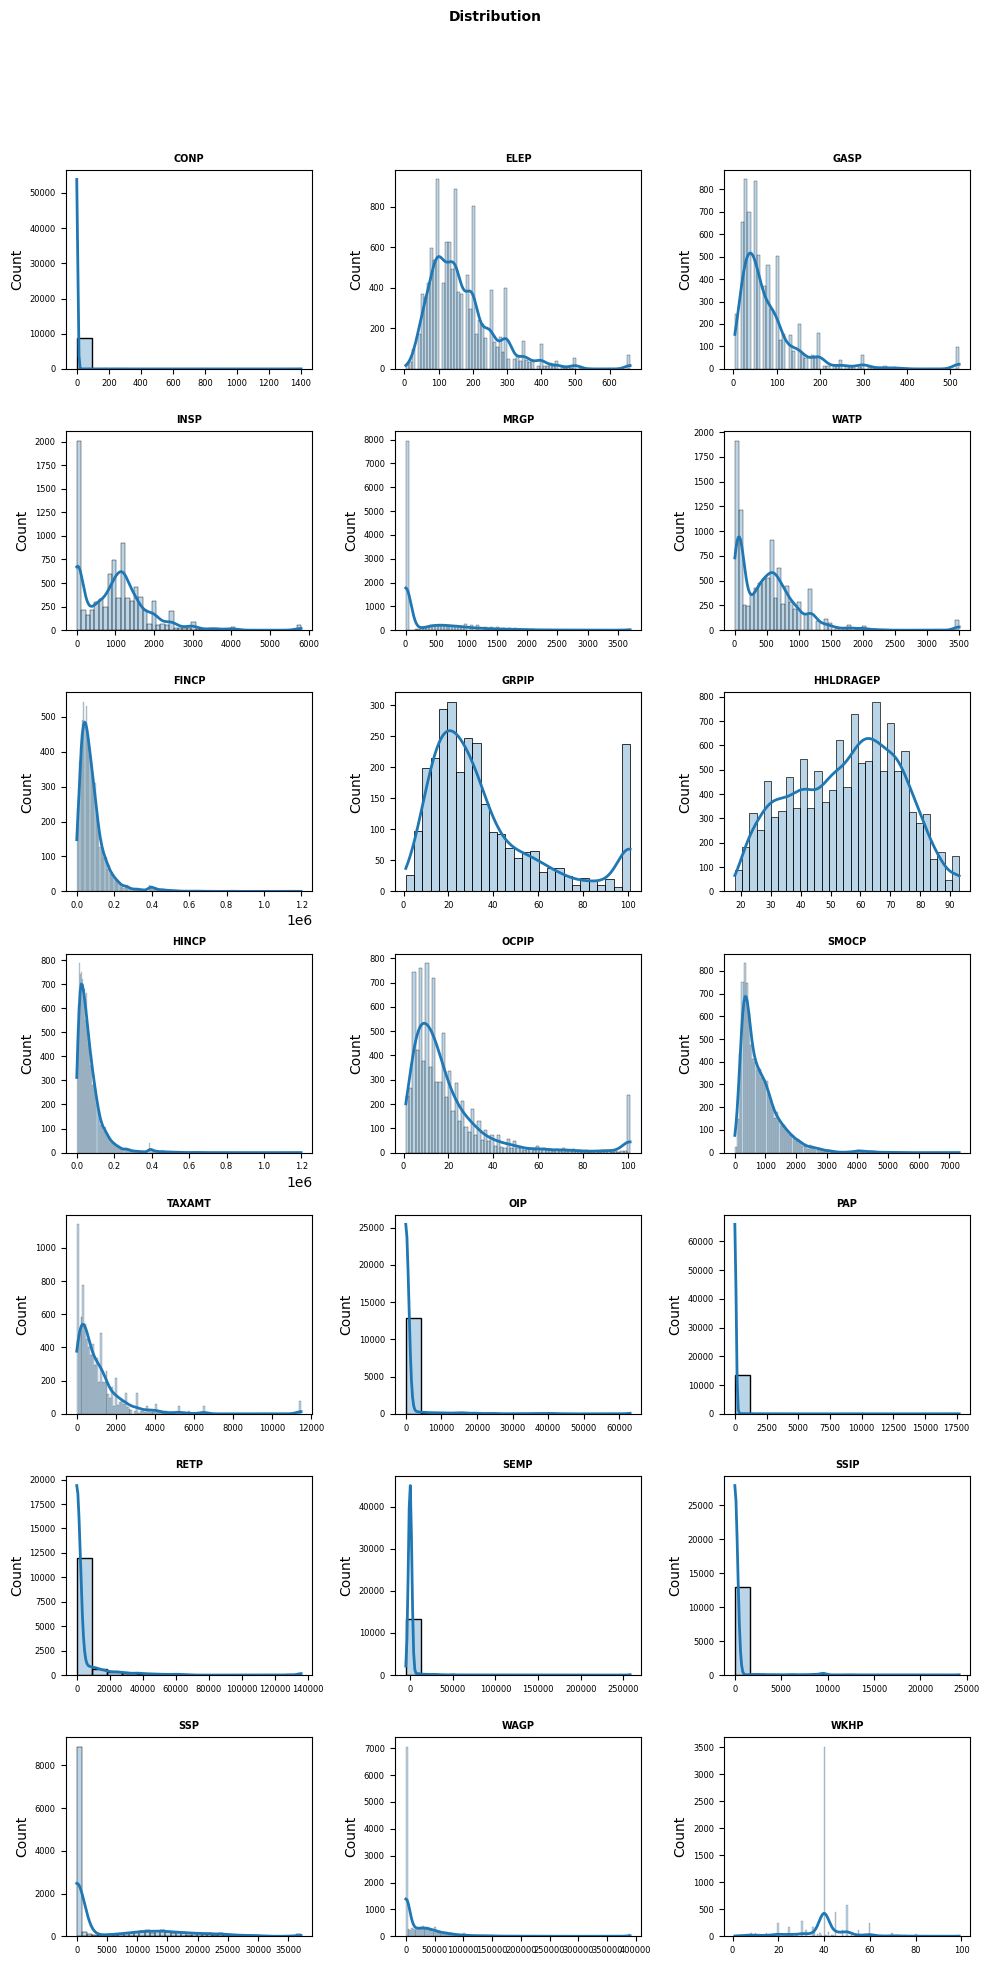

In [49]:
fig, axes = plt.subplots(nrows=7, ncols=3, figsize=(10,20))
axes = axes.flat
for i, colum in enumerate(true_floats):
    sns.histplot(
        data    = pums,
        x       = colum,
        stat    = "count",
        kde     = True,
        #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribution', fontsize = 10, fontweight = "bold")

In [50]:
pums['SSP'].describe()

count    13610.000000
mean      5157.239530
std       8400.216465
min          0.000000
25%          0.000000
50%          0.000000
75%      10400.000000
max      37100.000000
Name: SSP, dtype: float64

> Variables imputed with mean:
> WKHP, HHLDRAGEP, ELEP

> The rest will be imputed with the median to avoid long tailed effects on mean.

__Note__: before truly imputing there's a need to separate the pums dataframe into train-dev sets to avoid data leakage (the train set will "know" information about the test set).

* _The data frame "data" will be used for model selection/training/testing and keeping "pums" data frame for visualization._

In [51]:
target_name = "FS"
target = pums[target_name]
data = pums.drop(columns=[target_name])

In [57]:
for x in ['WKHP', 'HHLDRAGEP', 'ELEP']:
    pums.loc[pums[x].isnull(),x] = pums[x].mean()

In [58]:
for x in [col for col in true_floats if col not in ['WKHP', 'HHLDRAGEP', 'ELEP']]:
    pums.loc[pums[x].isnull(),x] = pums[x].median()

<Axes: >

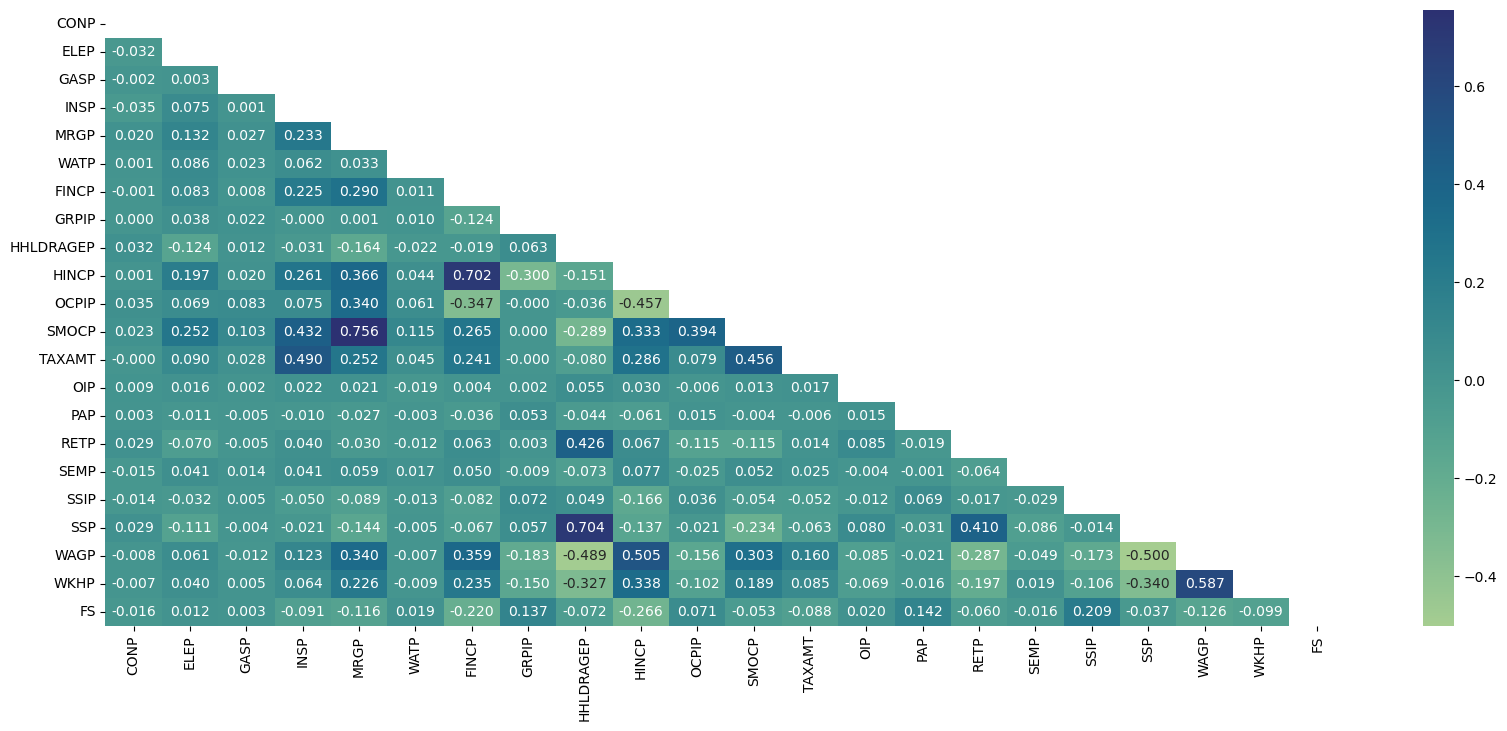

In [59]:
plt.figure(figsize=(20,8))
corr_matrix = pums[true_floats+['FS']].corr('spearman')
sns.heatmap(corr_matrix, 
            cbar=True, 
            annot=True,  
            mask = np.triu(np.ones_like(corr_matrix, dtype = bool)), 
            fmt='.3f', cmap=p)

* All correlations between FS and the numerical variables are small so we do not need to eliminate variables based on this criterion.
* Another step we could take is to average highly correlated variables, but we can wait to do that after if model selection fails to perform well.

#### Categorical Variables

For the rest of the variables the strategy is to re-encode to avoid dealing with the "0" category in different cases.

In [95]:
pums.dtypes.value_counts()

float64     168
category     10
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
dtype: int64

In [327]:
list_floats_cols = list(pums.select_dtypes(include=[ 'float64']).columns)
list_floats_cols[:9]

['ACCESSINET',
 'ACR',
 'AGS',
 'BATH',
 'BDSP',
 'BLD',
 'BROADBND',
 'COMPOTHX',
 'CONP']

In [324]:
pums[true_floats].head()

,CONP,ELEP,GASP,INSP,MRGP,WATP,FINCP,GRPIP,HHLDRAGEP,HINCP,OCPIP,SMOCP,TAXAMT,OIP,PAP,RETP,SEMP,SSIP,SSP,WAGP,WKHP
SERIALNO,,,,,,,,,,,,,,,,,,,,,
2021GQ0000060,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0000334,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0000904,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128
2021GQ0001018,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,27000.0,99.00000
2021GQ0001134,0.0,167.065272,60.0,1000.0,4.0,480.0,63700.0,28.0,55.368072,50000.0,14.0,642.0,725.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.53128


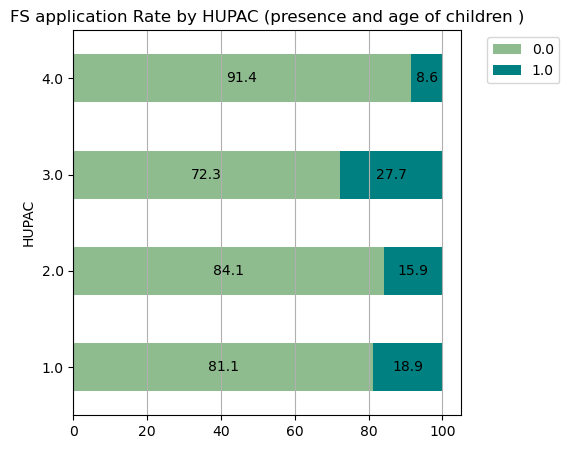

In [62]:
c = ['darkseagreen', 'teal']
df1 = pums.groupby(['HUPAC', 'FS']).size().unstack()
ax = df1.apply(lambda x : round((x/x.sum()*100),1), axis=1).plot(kind='barh', stacked=True, color=c, figsize=(5,5))
plt.title('FS application Rate by HUPAC (presence and age of children )')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(axis='x')
for container in ax.containers:
    ax.bar_label(container, label_type='center')
    
#N/A (GQ/vacant) 
#1 .With children under 6 years only 
#2 .With children 6 to 17 years only 
#3 .With children under 6 years and 6 to 17 years 
#4 .No children 

### Transform columns

X_train, X_test, Y_train, Y_test are the relevant sets for this steps.

In [96]:
data = pums.drop(columns=[target_name])
data.dtypes.value_counts()

float64     167
category     10
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
dtype: int64

In [97]:
list_floats_cols = data.select_dtypes(include=[ 'float64']).columns
list_floats_cols[:5]

Index(['ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP'], dtype='object')

In [75]:
ord_cols = [col for col in list_floats_cols if col not in true_floats]

In [91]:
#ord_cols.remove('FS')
ord_cols.remove('RWATPR')

In [92]:
for x in ord_cols:
    data[x] = data[x].astype('float').astype('Int64')

KeyError: 'HHLANP'

In [86]:
data.dtypes.value_counts()

float64     167
category      9
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
category      1
int64         1
dtype: int64

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, target, test_size=0.30, train_size=0.70, random_state=2023, stratify=target)

In [67]:
X_test.shape

(4085, 186)

In [77]:
ord_cols.remove('FS')

In [72]:
# Preprocessing pipeline

# imputing with median in all numeric variables is not too different strategy

num_pipeline = Pipeline([
  ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')), 
  ('scaler', StandardScaler())
])

pipeline = ColumnTransformer(
    [
     ('num_imputer', num_pipeline, true_floats),
     ('ord_encoder', OrdinalEncoder(), ord_cols)
     ]
    )

# One hot encoding can be used here in flag variables.

In [ ]:
categorical_features = X.select_dtypes(include="category").columns
integer_features = X.select_dtypes(exclude="object").columns

In [82]:
#  Fit the pipeline on the train data and then transform the test data 

scaled_train = pipeline.fit_transform(X_train) 

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [ ]:
scaled_test = pipeline.transform(X_test)
X_train = pd.DataFrame(scaled_train, index=X_train.index, columns=X_train.columns)
X_test = pd.DataFrame(scaled_test, index=X_test.index, columns=X_test.columns)

In [ ]:
# Resample the train data
# Do not resample the test data to prevent overfitting and poor generalization to the test data
X_train, y_train = SMOTE(sampling_strategy='minority').fit_resample(X_train, y_train)

In [68]:
pipeline

ColumnTransformer(transformers=[('num_imputer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['CONP', 'ELEP', 'GASP', 'INSP', 'MRGP',
                                  'WATP', 'FINCP', 'GRPIP', 'HHLDRAGEP',
                                  'HINCP', 'OCPIP', 'SMOCP', 'TAXAMT', 'OIP',
                                  'PAP', 'RETP', 'SEMP', 'SSIP', 'SSP', 'WAGP',
                                  'WKHP']),
                                ('ord_encoder', OrdinalEncoder(),
                                 ['ACCESSINET', 'ACR', 'AGS', 'BATH', 'BDSP',
                                  'BLD', 'BROADBND', 'COMPOTHX', 'DIALUP',
                                  'ELEFP', 'FS', 'FULFP', 'GASFP', 'HFL',
                                  'HISPEED', 'HOTWAT', 'LAPTOP', 'MRGI', 'MRGT',
                                  'MRGX', 'OTHSVCEX', 'REFR', 'RMSP', 'RWAT',
                                  'RWATPR', 'SATELLITE', 'SINK', 'SMARTPHONE',
                                  'STOV', 'TABLET', ...])])

In [ ]:
# Preprocessing
X_prep = pipeline.fit_transform(df)